In [2]:
%matplotlib inline 

import os
from os.path import join, dirname, basename, splitext, exists
import json
import glob

from rasterio.plot import show
import rasterio
from rasterio.profiles import DefaultGTiffProfile
import matplotlib.pyplot as plt
import xmltodict
from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import mapping

In [3]:
data_dir = '/opt/data/alimentiv-histo/'
image_dir = join(data_dir, 'EOE_Images')
label_dir = join(data_dir, 'Layer Data EOE_Images')

output_dir = join(data_dir, 'output')
new_label_dir = join(output_dir, 'labels')
new_aoi_dir = join(output_dir, 'aois')
new_qgis_aoi_dir = join(output_dir, 'qgis-aois')
if not exists(new_label_dir):
    os.makedirs(new_label_dir)
if not exists(new_aoi_dir):
    os.makedirs(new_aoi_dir)
if not exists(new_qgis_aoi_dir):
    os.makedirs(new_qgis_aoi_dir)
    
image_paths = glob.glob(join(image_dir, '*'))
image_fns = [splitext(basename(x))[0] for x in image_paths]
dots_per_mm = {x: 4000 if len(x) == 5 else 5000 for x in image_fns}
label_paths = [join(label_dir, f'{x}.tif') for x in image_fns]
fov_paths = [join(label_dir, f'{x}.xml') for x in image_fns]

In [3]:
id2fov = {}
for fov_path, image_fn in zip(fov_paths, image_fns):
    with open(fov_path) as fd:
        fov_dict = xmltodict.parse(fd.read())
    regions = fov_dict['LayerData']['Regions']
    if regions:
        if len(regions['Object']) != 2:
            print(f'Warning: > 1 FOV in {fov_path}')
        points = regions['Object'][1]['Vertices']['Vertex']
        fov = [(float(p['@X']), float(p['@Y'])) for p in points]
        id2fov[image_fn] = fov

(array([49.,  6.,  2.,  1.,  2.,  0.,  1.,  0.,  0.,  2.]),
 array([ 0.15288403,  1.75628239,  3.35968076,  4.96307913,  6.5664775 ,
         8.16987587,  9.77327424, 11.37667261, 12.98007097, 14.58346934,
        16.18686771]),
 <BarContainer object of 10 artists>)

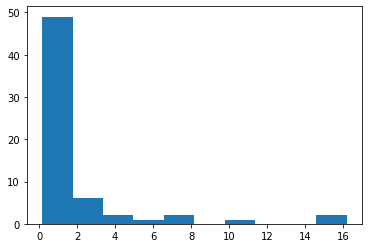

In [9]:
shapes = []
for image_path in image_paths:
    shapes.append(rasterio.open(image_path).shape)

shapes = np.array(shapes)
max_pixels = shapes.max(axis=0).prod()
gbs = shapes.prod(axis=1) / (10 ** 9)
# distribution of images sizes in GBs
# we can't load the big ones into RAM
plt.hist(gbs)

In [ ]:
for image_fn, image_path in zip(image_fns, image_paths):
    print(f'Processing {image_path}')
    fov = id2fov[image_fn]
    _dots_per_mm = dots_per_mm[image_fn]
    new_label_path = join(new_label_dir, f'{image_fn}.tif')
    new_aoi_path = join(new_aoi_dir, f'{image_fn}.json')
    
    img_src = rasterio.open(image_path)
    img_shape = img_src.shape
    print(img_shape)
    height, width = img_shape
    img_center = np.array([[width, height]]) // 2
        
    label_path = join(label_dir, f'{image_fn}.tif')
    label_src = rasterio.open(label_path)
    label_arr = label_src.read(1)
    label_arr[label_arr != 0] = 1
    
    # convert to image pixel coords
    fov = np.array(fov)
    # negate the y dimension so that the value increases as we go down the array
    fov[:, 1] *= -1
    fov = ((fov * _dots_per_mm) + img_center).round().astype(int)
    fov_poly = Polygon(fov)
    fov_center = np.array(fov_poly.centroid.xy).squeeze()
    
    # shift label array to center of FOV
    label_height, label_width = label_arr.shape
    label_half_width = np.array([label_width, label_height]) // 2
    label_offset = (fov_center - label_half_width).astype(np.int32)
    label_overlay = np.zeros(img_shape, dtype=np.uint8)
    label_overlay[
        label_offset[1]:label_offset[1] + label_height, 
        label_offset[0]:label_offset[0] + label_width] = label_arr
    
    # save new labels
    profile = DefaultGTiffProfile(count=1, width=label_overlay.shape[1], height=label_overlay.shape[0])
    with rasterio.open(new_label_path, 'w', **profile) as dst:
        dst.write(label_overlay, 1)
        
    # save with y dim negated for visualization in QGIS
    for orientation in ['neg', 'pos']:
        fov[:, 1] *= -1
        fov_poly = Polygon(fov)
        aoi_dict = {
            'type': 'FeatureCollection',
            'features': [
                {
                    'type': 'Feature',
                    'geometry': mapping(fov_poly),
                }
            ]
        }
        out_dir = new_qgis_aoi_dir if orientation == 'neg' else new_aoi_dir
        out_path = join(out_dir, f'{image_fn}.json')
        with open(out_path, 'w') as aoi_fd:
            aoi_fd.write(json.dumps(aoi_dict))

Processing /opt/data/alimentiv-histo/EOE_Images/1.tif
(25500, 27995)
Processing /opt/data/alimentiv-histo/EOE_Images/10.tif
(42500, 33505)
Processing /opt/data/alimentiv-histo/EOE_Images/11.tif
(33500, 21997)
Processing /opt/data/alimentiv-histo/EOE_Images/12.tif
(23414, 25162)
Processing /opt/data/alimentiv-histo/EOE_Images/12002.tiff
(69632, 78848)
Processing /opt/data/alimentiv-histo/EOE_Images/12022.tiff
(42496, 56320)
Processing /opt/data/alimentiv-histo/EOE_Images/12026.tiff
(29696, 86016)
Processing /opt/data/alimentiv-histo/EOE_Images/12030.tiff
(20992, 65024)
Processing /opt/data/alimentiv-histo/EOE_Images/12033.tiff
(65536, 104448)
Processing /opt/data/alimentiv-histo/EOE_Images/12048.tiff
(28160, 58880)
Processing /opt/data/alimentiv-histo/EOE_Images/12053.tiff
(20992, 59904)
Processing /opt/data/alimentiv-histo/EOE_Images/12071.tiff
(89600, 164352)
